In [ ]:
### Takes a set of budfields, and plots them for a growth season
### You need to supply the correct grid files
### Also we have the bathymetry fr pretty

### old code Jan 2021 using basemap



In [149]:
import data_year as dy
import grid_set as gs
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import glob
import datetime as dt
import gc
import copy

In [232]:
budget_load = ['intensification','advection','divergence','residual','ice_drift_x','ice_drift_y']
class budget_result_monthly(dy.data_year):
    def __init__(self, directory,verbos = False,var_load = budget_load,regrid = lambda x: x):
        self.path = directory
        files = glob.glob(directory+'*.nc')
        #### find all the files
        self.n_t = 0
        self.Fdates = []
        dates_list = []
        for file in files: 
            if verbos: print(file) 
            try:
                date_str = file.split('budfields_')[1]
                date_str = date_str.split('.nc')[0]
                date_use = dt.datetime.strptime(date_str,'%Y%m%d')
                if verbos: print(date_str) 
            except ValueError:
                pass
            except IndexError:
                pass
            else:
                self.n_t += 1
                self.Fdates.append(date_use)
                if date_use.day > 1:
                    date_use = date_use.replace(day = 1)
#                     if date_use.month <6:
#                         date_use+=relativedelta(months=1)
                dates_list.append(date_use)
        self.Fdates.sort()
        dates_list.sort()
        #### create dates array
        #### if we are regridding, set dimensions from reggridder
        if type(regrid) ==  gs.Gs2Gs:
            m,n = regrid.mesh_new[0].shape
        else: ## use read in
            #### open first file 
            d = self.Fdates[0]
            f_name = self.path + 'budfields_' + d.strftime('%Y%m%d') + '.nc'
            #### get dims
            m,n = Dataset(f_name).variables['lon'].shape[1:]
        #### create attributes
        for vl in var_load:
            if verbos: print(vl)
            setattr(self,vl,np.empty([self.n_t,m,n]))
        #### load the data from
        for n,d in enumerate(self.Fdates):
            f_name = self.path + 'budfields_' + d.strftime('%Y%m%d') + '.nc'
            f_nc = Dataset(f_name)
            for vl in var_load:
                x = getattr(self,vl)
                x[n] = regrid(np.squeeze(f_nc.variables[vl]))
        #### set one data
        data = copy.copy(getattr(self,var_load[0]))
#         data = getattr(self,var_load[0])
        #### initialise the data_year using data
        super().__init__(data,dates_list)
        
    def set_var(self,varname):
        """
        use a variable name to set as 'data'
        this allows all the dy methods to work correctly
        """
        self.data = copy.copy(getattr(self,varname))
#         data = getattr(self,varname)
        gc.collect()
        

In [230]:
### SET the grid for the output data
### You 'should' be able to change the projecton here

m = Basemap(projection='npstere',boundinglat=65,lon_0=0)
G = gs.grid_set(m)
# G.load_grid('grids/osisaf_gs.npz')
G.load_grid('grids/Pathfinder_gs.npz')
G.reproject(m)
G.get_ptp()

Loaded a grid: grids/Pathfinder_gs.npz


In [236]:
#### HERE WE SET THE OUTPUT DATA
## The directory should be full of the budfeilds files from the budget process tool
## monthlies only

# save_dir = '/Users/H/PREMELT/Budget/Outputs/out_OSISAF_nt_CPOM/'
save_dir = '/Users/H/PREMELT/Budget/Outputs/out_Pathfinder_nt_CPOM/'
test_bud = budget_result_monthly(save_dir)

In [223]:
### regridding the topax bathymetry
### 1 loading grid and data

filepath='/Users/H/PREMELT/Budget/Michel_budget_plots/HarryCodePlot/'

#data1=Dataset(filepath+'topaz_V4_myocean_arctic_grid1to8_da_class1_19990915.nc',"r")    
data1=Dataset(filepath+'topaz_V4_myocean_arctic_grid1to8_da_class1_19910115.nc',"r") 
lon_TOPAZ=data1.variables['longitude'][:,:]
lat_TOPAZ=data1.variables['latitude'][:,:]
topaz_depth=data1.variables['model_depth'][:,:]
Gtopaz = gs.grid_set(m)
Gtopaz.set_grid_lon_lat(lon_TOPAZ.data,lat_TOPAZ.data)
### regrid now

Got a grid res =  881  x  609
Note that all grid info is in nx x ny grids, whilst data is in nx x ny


In [237]:
### 2 regridder object (slow)
Gtop2G = gs.Gs2Gs(Gtopaz,G)

In [238]:
### 3 regirdding (quick)
depth_nn = Gtop2G.rg_array(topaz_depth)

In [225]:
nmonths = 7
list_months_titles=['October','November','December','January','February','March','April']
list_ylabels=['Intensification','Advection','Divergence','Residual']
def plot_budget_growth_season(bud_month,year,GS,save_dir = False,show_plot = True,plot_type='.png',
                              depth_nn=False,drift_vectors = False,rv=(15,0.2,0.01),dbug=False):
    if drift_vectors:
        rm = int(GS.m/rv[0])
        rn = int(GS.n/rv[0])
        ra = np.sqrt(rm+rn)
        ra=ra*rv[1]
        ### temp vector variables
        vec_plot = np.empty([2,nmonths,GS.m,GS.n])
        budstr = 'ice_drift_x'
        bud_month.set_var(budstr)
        for mn in range(nmonths):
            year_u = year
            m_u = np.mod(mn-3,12)
            if m_u > 6: year_u = [y-1 for y in year_u]
            vec_plot[0,mn,:,:] = bud_month.clim_map(periods=[m_u],year_set=year_u)
        budstr = 'ice_drift_y'
        bud_month.set_var(budstr)
        for mn in range(nmonths):
            year_u = year
            m_u = np.mod(mn-3,12)
            if m_u > 6: year_u = [y-1 for y in year_u]
            vec_plot[1,mn,:,:] = bud_month.clim_map(periods=[m_u],year_set=year_u)
        for mn in range(nmonths):
            vec_plot[0,mn],vec_plot[1,mn]=GS.rotate_vectors_to_plot(vec_plot[0,mn],vec_plot[1,mn])
    fig,ax = plt.subplots(4,nmonths,figsize=(22,13))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.)
    for bn, budstr in enumerate(budget_load[:4]):
        bud_month.set_var(budstr)
        for mn in range(nmonths):
#             mt = copy.copy(m)
#             mt.ax = ax[bn,mn]
#             if drift_vectors:
            mt = Basemap(projection='npstere',boundinglat=65,lon_0=0, ax=ax[bn,mn])
            mt.drawcoastlines(linewidth=0.4)
            mt.fillcontinents(color='lightgray',lake_color='white', alpha=0.5)
            mt.drawmapboundary(fill_color='white')
            mt.drawparallels(np.arange(60,90,5),linewidth=0.5, dashes=[1,5])
            mt.drawmeridians(np.arange(0,360,10),linewidth=0.5, dashes=[1,5])
            if type(depth_nn) is not bool:
                llevels = np.arange(-2000,0,250) # check etopo.ravel().max()
                s = mt.contour(GS.xpts, GS.ypts, -depth_nn, vmin=-8000, vmax=0,levels=llevels,colors='k', linestyles='-',alpha=0.05)
            
            #### get the array of interest - return logical if it exists
            year_u = year
            m_u = np.mod(mn-3,12)
            if m_u > 6: year_u = [y-1 for y in year_u]
            try:
                budget = bud_month.clim_map(periods=[m_u],year_set=year_u)
                budget[budget==0] = np.nan
                llevels = np.arange(-6,6,1)
                s = mt.contourf(GS.xpts, GS.ypts, 86400.*12.*budget, vmin=-6, vmax=6,levels=llevels,cmap=plt.cm.RdYlBu, extend='both')
#                 mt.pcolormesh(GS.xptp, GS.yptp, 86400.*12.*budget, vmin=-6, vmax=6,cmap=plt.cm.RdYlBu, rasterized=True)
            except TypeError:
                pass
            try:
#                 mt.quiver(B.xpts[::rm,::rn],B.ypts[::rm,::rn],ur[::rm,::rn],vr[::rm,::rn],scale 
                mt.quiver(GS.xpts[::rm,::rn],GS.ypts[::rm,::rn],
                          vec_plot[0,mn,::rm,::rn],vec_plot[1,mn,::rm,::rn],
                          scale = ra,width=rv[2])
            except TypeError:
                pass
            if (mn==0):
                ax[bn,mn].set_ylabel(list_ylabels[bn], rotation=90, size='large')

            if (bn==0 and year[0]==year[1]):
                ax[bn,mn].set_title(bud_month.print_date(bud_month.yrpd[year_u[0],m_u],'%B %Y'))
            elif (bn==0):
                ax[bn,mn].set_title(bud_month.print_date(bud_month.yrpd[year_u[0],m_u],'%B %Y - ')+
                                    bud_month.print_date(bud_month.yrpd[year_u[1],m_u],'%Y'))


            if (mn == nmonths-1):
                divider = make_axes_locatable(ax[bn,mn])
                cax = divider.append_axes('right', size='5%', pad=0.05)
                plt.colorbar(s, cax=cax, pad=0.1)
#                 plt.colorbar(s,  pad=0.1)
            else:
                divider = make_axes_locatable(ax[bn,mn])
                cax = divider.append_axes('right', size='5%', pad=0.05)
                cax.axis('off')
            if dbug:
                print('dbug: stopping early')
                plt.show()
                return False
    if type(save_dir) == str: 
        if (year[0]==year[1]):
            print_date = bud_month.print_date(bud_month.yrpd[year[0],m_u],'%Y')
        else:
            print_date = (bud_month.print_date(bud_month.yrpd[year[0],m_u],'%Y-') + 
                          bud_month.print_date(bud_month.yrpd[year[1],m_u],'%Y'))
        fig.savefig(save_dir+'growth_season_maps_'+print_date+plot_type,bbox_inches='tight')
#     plt.subplots_adjust(wspace=0.05, hspace=0.05)
    if show_plot: plt.show()

/Users/H/PREMELT/Budget/Budget_tool/data_year.py:565: RuntimeWarning: Mean of empty slice
  axis = 0)
/Users/H/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3132: RuntimeWarning: invalid value encountered in greater_equal
  farnorth = np.abs(lats+dlat) >= 90.0


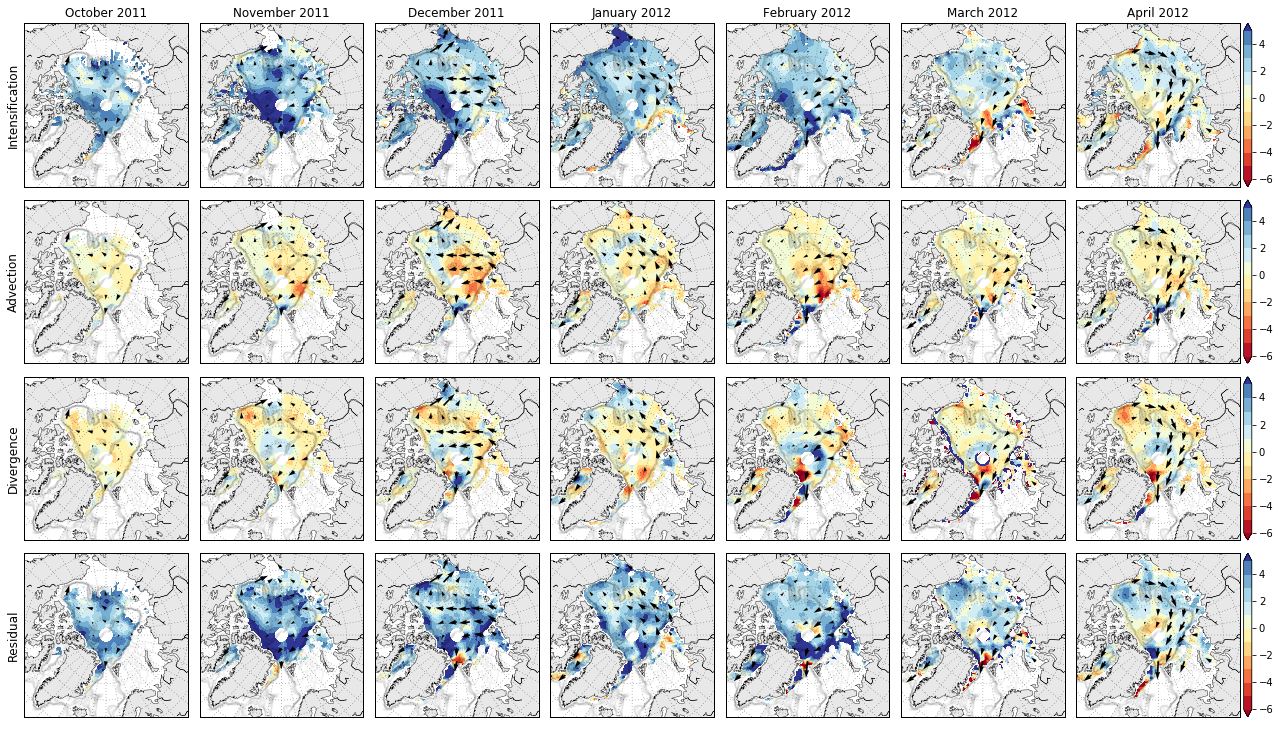

In [239]:
# save_dir = '/Users/H/PREMELT/Budget/Outputs/out_OSISAF_nt_CPOM/'
plot_budget_growth_season(test_bud,[3,3],G,depth_nn=depth_nn,
                          drift_vectors=True,rv=(20,0.2,0.01),dbug = False,save_dir=save_dir)
#### options
# test_bud = loaded budfields object from before
# [2,2] sets the year range to plot
### [2,2] is for the 2 year on file (ignore [0,0] as this in the first years Oct,Nov,Dec)
### [1,5] will average over years 1 to 5
### [1,test_bud.nyrs-1] will average over all years
# G = the grid object
# depth_nn is the topaz data
# drift_vectors = Truw plots drift vectors
# rv = arrow ploting optons
### rv[0] is approx no of arrows in each direction, increasing this give more arrows
### rv[1] is the arrow scale, decreasing this gives longer arrows
### rv[2] is the arrow thickness, increasign this give 'thicker' arrows
# dbug = True does the first pane and exits to speed up trouble shooting
# save_dir = 'directory' will save the firgure

### there are lots of defualt values here, for example
### plot_budget_growth_season(test_bud,[2,2],G) will just plot the fields with no bathymetry or vectors and not save it

In [241]:
#### loop all years (should be automatic)
[plot_budget_growth_season(test_bud,[y,y],G,depth_nn=depth_nn,show_plot=False
                          drift_vectors=True,rv=(20,0.2,0.01),dbug = False,save_dir=save_dir) 
                         for y in range(1,test_bud.nyrs)]